Latent Distribution Approximation
===

# Content
1. Random Multimodel Synthetic Distribution Generator
2. Hamilton Monte Carlo Inference
3. Gaussian Distribution based Regular Variational Inference
4. Fully Connected Network based Deep Variational Inference
5. Normalizing Flow based Deep Variational Inference

In [1]:
model_comparison = dict()

## Create Random Distribution

In [2]:
from utils.supports import *
import scipy.stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
# import seaborn aspi sns
# sns.set(style='white', rc={'image.cmap': 'Blues'})
import pickle
import numpy as np
from tqdm import tqdm
from scipy.stats import norm

import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Tensorflow reimplementation to support auto-differentiation
tf.reset_default_graph()
class Generator():
    def __init__(self, dimension, num_cluster):
        self.dim = dimension
        self.num_cluster = num_cluster
        self.sample_distribution()
        self.build_graph()
        
    def set_distribution(self, mus, covs):
        self.distrib = self.multivariate_normal(mus.astype(np.float32), covs.astype(np.float32))
        self.mus = mus
        self.covs = covs
        
    def save(self):
        return self.mus, self.covs
        
    def sample_distribution(self):
        mus = []
        covs = []
        for k in range(self.num_cluster):
            mu = -2 + 4*rand(self.dim)
            cov = .5*scipy.stats.invwishart.rvs(df=self.dim+1,scale=eye(self.dim))
            mus.append(mu)
            covs.append(cov)
        mus = np.stack(mus)
        covs = np.stack(covs)
        self.distrib = self.multivariate_normal(mus.astype(np.float32), covs.astype(np.float32))
        self.mus = mus
        self.covs = covs
    
    def multivariate_normal(self, mu, cov):      
        return tf.contrib.distributions.MultivariateNormalFullCovariance(mu, cov)
    
    def build_graph(self):
        self.obs = tf.placeholder(tf.float32, shape=[None, self.dim], name='q')
        #p(x)
        with tf.variable_scope('log_like'):
            self.probs = tf.reduce_sum(
                tf.map_fn(self.distrib.prob, 
                          tf.reshape(tf.tile(self.obs,[1,self.num_cluster]),[-1,self.num_cluster,self.dim])), 
                axis=1)
            self.log_probs = -tf.log(self.probs+1e-30)
        with tf.variable_scope('gradient'):
            self.gradient = tf.gradients(tf.reduce_sum(self.log_probs), self.obs)
            
        self._sesh = tf.Session()
        
    def get_density(self, observation):
        density = self._sesh.run(self.probs,
                                 feed_dict={self.obs: observation})
        return density
        
    def get_log_density(self, observation):
        log_like = self._sesh.run(self.log_probs,
                                  feed_dict={self.obs: observation})
        return log_like
    
    def get_gradient(self, observation):
        gradient = self._sesh.run(self.gradient, 
                                  feed_dict={self.obs: observation})
        return gradient[0]
    
    def sample_data(self, size):
        # Sample from clusters
        clusters = np.random.choice(self.num_cluster, size)
        index = range(size)
        sample_index = np.vstack((index,clusters)).T
        samples = tf.gather_nd(self.distrib.sample(size), sample_index)
        return self._sesh.run(samples)
        

In [4]:
g = Generator(2,5)

In [55]:
xs = arange(-7,7,.2)
x1,x2 = meshgrid(xs,xs)

In [56]:
samples = g.sample_data(1000)

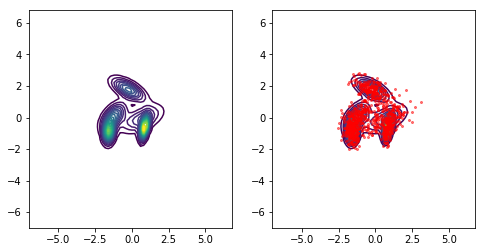

In [57]:
# make a plot of the target density
plt.clf()
fig,ax = plt.subplots(1, 2, figsize=(8, 4))
xs = arange(-7,7,.2)
x1,x2 = meshgrid(xs,xs)
obs = []
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        obs.append([x1[i,j],x2[i,j]]) 
P = g.get_density(obs)
P = P.reshape(len(xs),len(xs))
ax[0].contour(x1,x2,P,30)
ax[1].contour(x1,x2,P,30)
ax[1].plot(samples[:,0],samples[:,1],'ro',markersize=2, alpha=.5)

In [58]:
model_comparison['True'] = [samples, P]

In [9]:
mus, covs = g.save()

In [10]:
with open('gmm.pickle', 'wb') as handle:
    pickle.dump({'gmm':[mus, covs]}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
q = np.random.normal(0, 1, size=[10, 2])

In [12]:
g.get_gradient(q)

array([[-0.5775, -0.803 ],
       [ 2.0126, -1.4034],
       [-0.8318,  0.2575],
       [ 0.0394, -2.865 ],
       [ 4.0282, -1.2317],
       [ 3.9767,  4.7266],
       [ 0.9517,  1.374 ],
       [-3.3147, -3.2033],
       [ 1.1067,  0.3793],
       [ 0.3297,  1.9585]], dtype=float32)

In [13]:
from functools import wraps

def compareto(y):
    def _my_decorator(func):
        def _decorator(*args, **kwargs):
            response = func(*args, y=y)
            return response
        return wraps(func)(_decorator)
    return _my_decorator

@compareto(y=samples)
def maximum_mean_discrepancy(x, y=None):
    x_mean = np.mean(x, axis=0)
    y_mean = np.mean(y, axis=0)
    subtract = x_mean-y_mean
    return np.linalg.norm(subtract)

# HMC

In [14]:
class HMC(object):
    def __init__(self, generator, batch_size, latent_dim):
        self.generator = generator
        self.batch_size = batch_size
        self.latent_dim = latent_dim

    def sampler(self, current_q, L=35, epsilon=0.01):
        q = current_q
        p = np.random.normal(0, 1, size=[self.batch_size, self.latent_dim])
        current_p = p

        # Leapfrog
        p = p - epsilon * self.generator.get_gradient(q)/2

        for l in range(L):
            q = q + epsilon * p[0]

            if l != L - 1:
                p = p - epsilon * self.generator.get_gradient(q)

        p = p - epsilon * self.generator.get_gradient(q)/2
        p = -p

        current_U = self.generator.get_log_density(current_q)
        current_K = np.sum(np.square(current_p), axis=1) / 2

        proposed_U = self.generator.get_log_density(q)
        proposed_K = np.sum(np.square(p), axis=1) / 2

        rate = np.random.random_sample(size=self.batch_size)
        cond = rate < np.exp(current_U-proposed_U+current_K-proposed_K)
        pos = np.concatenate((q, np.array([proposed_U]).T), axis=1)
        neg = np.concatenate((current_q, np.array([current_U]).T), axis=1)
        q_U = np.array([xv if c else yv for (c,xv,yv) in zip(cond,pos,neg)])
        precentage = sum(cond)/float(len(cond))
        return q_U[:, :-1], precentage #, q_U[:, -1]

    def gather_samples(self, size, burn_in=5, L=35, epsilon=0.01):
        q = np.random.normal(0, 1, size=[self.batch_size, self.latent_dim])
        precentages = []

        for i in tqdm(range(burn_in)):
            q, _ = self.sampler(q, L, epsilon)

        # Gather samples
        samples = []
        for i in tqdm(range(size)):
            q, precentage = self.sampler(q, L, epsilon)
            samples.append(q)
            precentages.append(precentage)

        return np.vstack(samples), np.average(precentages)

In [15]:
hmc = HMC(g, 1, 2)

In [16]:
# plt.clf()
# fig,ax = plt.subplots(figsize=(20, 20))
# ax.contour(x1,x2,P,30)
# zs, accept_rate = hmc.gather_samples(500, burn_in=10000, L=30, epsilon=0.01)
# print("Acceptance Rate:{0}".format(accept_rate))
# ax.plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
# mmd = maximum_mean_discrepancy(zs)
# ax.set_xlabel('accept:{0}\n mmd:{1}'.format(accept_rate, mmd))
# fig.tight_layout()
# plt.show()

In [17]:
# mmd

In [18]:
# epsilons = np.logspace(-3, 0, 25, endpoint=True)
# #epsilons = np.linspace(0.3, 0.5, num=25)
# plt.clf()
# fig,ax = plt.subplots(5, 5, figsize=(20, 20))
# for i, epsilon in enumerate(epsilons):
#     ax[i/5,i%5].contour(x1,x2,P,30)
#     zs, accept_rate = hmc.gather_samples(1000, burn_in=10000, L=10, epsilon=epsilon)
#     print("Acceptance Rate:{0}".format(accept_rate))
#     ax[i/5,i%5].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
#     mmd = maximum_mean_discrepancy(zs)
#     ax[i/5,i%5].set_xlabel('epsilon:{0}\n accept:{1}\n mmd:{2}'.format(epsilon, accept_rate, mmd))
# fig.tight_layout()
# plt.show()

In [19]:
#epsilons = np.logspace(-3, 0, 25, endpoint=True)
# epsilons = np.linspace(0.1, 0.5, num=5)
# plt.clf()
# fig,ax = plt.subplots(1, 5, figsize=(20, 5))
# for i, epsilon in enumerate(epsilons):
#     ax[i].contour(x1,x2,P,30)
#     zs, accept_rate = hmc.gather_samples(1000, burn_in=10000, L=10, epsilon=epsilon)
#     print("Acceptance Rate:{0}".format(accept_rate))
#     ax[i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
#     mmd = maximum_mean_discrepancy(zs)
#     ax[i].set_xlabel('epsilon:{0}\n accept:{1}\n mmd:{2}'.format(epsilon, accept_rate, mmd))
# fig.tight_layout()
# plt.show()

In [20]:
# epsilons = np.linspace(0.7, 1.0, num=5)
# plt.clf()
# fig,ax = plt.subplots(1, 5, figsize=(20, 5))
# for i, epsilon in enumerate(epsilons):
#     ax[i].contour(x1,x2,P,30)
#     zs, accept_rate = hmc.gather_samples(1000, burn_in=10000, L=10, epsilon=epsilon)
#     print("Acceptance Rate:{0}".format(accept_rate))
#     ax[i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
#     mmd = maximum_mean_discrepancy(zs)
#     ax[i].set_xlabel('epsilon:{0}\n accept:{1}\n mmd:{2}'.format(epsilon, accept_rate, mmd))
# fig.tight_layout()
# plt.show()

In [21]:
zs, accept_rate = hmc.gather_samples(1000, burn_in=10000, L=10, epsilon=0.3)
mmd = maximum_mean_discrepancy(zs)
model_comparison['HMC'] = [zs, accept_rate, mmd]

100%|██████████| 1000/1000 [00:32<00:00, 30.31it/s]


# Regular Variational Inference

### Packages

In [22]:
from tensorflow.contrib import layers
from utils.planar import Planar
from utils.activations import lrelu,leaky_rectify
from utils.jacobian import get_determinant, get_jacobian
from utils.codings import planar_projector, fc_noise_projector
from tensorflow.contrib.framework import arg_scope

from collections import defaultdict

In [23]:
class VariationalInference(object):

    def __init__(self, latent_dim, mus, covs,
                 learning_rate=1e-3,
                 ):
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.num_cluster = len(mus)
        self.set_distribution(mus, covs)
        self.build_graph()
        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)
        self.history = {'kl':[], 'mmd':[]}
        
    def set_distribution(self, mus, covs):
        self.distrib = self.multivariate_normal(mus.astype(np.float32), covs.astype(np.float32))
        self.mus = mus
        self.covs = covs
        
    def multivariate_normal(self, mu, cov):      
        return tf.contrib.distributions.MultivariateNormalFullCovariance(mu, cov)

    def get_name(self):
        return "VI"

    def build_graph(self):
        self.noise = tf.placeholder(tf.float32, shape=[None, self.latent_dim])
        with tf.variable_scope('vi'):
            cov = tf.Variable(tf.eye(self.latent_dim))
            mu = tf.Variable(tf.zeros(self.latent_dim))
            self.obs = mu + tf.matmul(self.noise, cov)
            with tf.variable_scope('log-det'):
                determinant = 0.5*get_determinant(2*pi*e*tf.matmul(cov, tf.transpose(cov)))
                self.logdet = -tf.log(determinant)
                
            with tf.variable_scope('log-like'):
                probs = tf.reduce_sum(
                    tf.map_fn(self.distrib.prob, 
                              tf.reshape(tf.tile(self.obs,[1,self.num_cluster]),
                                         [-1,self.num_cluster,self.latent_dim])), 
                    axis=1)
                self.loglike = -tf.log(probs+1e-30)
            trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "vi")
            with tf.variable_scope('loss'):
                self.loss = tf.reduce_sum(self.logdet + self.loglike)
                
                with tf.variable_scope('optimizer'): 
                    self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=self.loss, 
                                                                            method='L-BFGS-B', 
                                                                            var_list=trainable_variables,
                                                                            options={'maxiter': 100})
      
    def call_back(self, loss, obs):
        self.history['kl'].append(loss)
        self.history['mmd'].append(maximum_mean_discrepancy(obs))
    
    def update(self, noise):
        self.optimizer.minimize(session=self._sesh, 
                                feed_dict={self.noise:noise},
                                loss_callback=self.call_back,
                                fetches=[self.loss, self.obs]
                               )
    
    def sampler(self, noise):
        sample = self._sesh.run(self.obs, feed_dict={self.noise:noise})
        return sample
    
    def get_history(self):
        return self.history
    
    def clean_history(self):
        self.history = defaultdict()

In [24]:
tf.reset_default_graph()
vi = VariationalInference(2, mus, covs)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: -2865.352783
  Number of iterations: 11
  Number of functions evaluations: 30


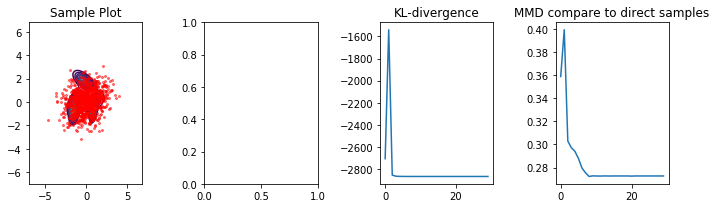

In [25]:
noise = np.random.normal(size=[1000, 2])
plt.clf()
fig,ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].contour(x1,x2,P,30)
vi.update(noise)
zs = vi.sampler(noise)
history = vi.get_history()
#fcn.clean_history()
ax[0].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
ax[0].set_title('Sample Plot')

ax[2].plot(history['kl'])
ax[2].set_title('KL-divergence')
ax[3].plot(history['mmd'])
ax[3].set_title('MMD compare to direct samples')
#vi.clean_history()
fig.tight_layout()
plt.show()

In [26]:
model_comparison['RegularVI'] = [zs, history['kl'], history['mmd']]

# Deep Variational Inference

### Base Class

In [27]:
class DeepVariationalInference(object):

    def __init__(self, latent_dim, mus, covs,
                 optimizer=tf.train.AdamOptimizer,
                 learning_rate=1e-3,
                 activation=tf.tanh
                 ):
        """
        """
        self.latent_dim = latent_dim
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.activation = activation
        self.num_cluster = len(mus)
        self.set_distribution(mus, covs)
        self.build_graph()
        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)
        self.history = {'kl':[], 'mmd':[]}
        
    def set_distribution(self, mus, covs):
        self.distrib = self.multivariate_normal(mus.astype(np.float32), covs.astype(np.float32))
        self.mus = mus
        self.covs = covs
        
    def multivariate_normal(self, mu, cov):      
        return tf.contrib.distributions.MultivariateNormalFullCovariance(mu, cov)

    def get_name(self):
        pass

    def build_graph(self):
        pass

    def update(self, noise, partialx, mask):
        pass
    
        
    def get_history(self):
        return self.history
    
    def clean_history(self):
        self.history = defaultdict()

### Fully Connected Network Based DVI

In [28]:
class FullyConnectedVIN(DeepVariationalInference):
    
    def get_name(self):
        return "FCN"
    
    def build_graph(self):
        
        with tf.variable_scope('dvi'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self.latent_dim])
            with tf.variable_scope('projector'):
                self.obs = fc_noise_projector(self.noise, 1, self.latent_dim, activation=tf.tanh)
            with tf.variable_scope('log-det'):
                determinant = get_determinant(get_jacobian(self.obs, self.noise))
                self.logdet = -tf.log(determinant)
            
            trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "dvi/projector")
            
            with tf.variable_scope('log-like'):
                probs = tf.reduce_sum(
                    tf.map_fn(self.distrib.prob, 
                              tf.reshape(tf.tile(self.obs,[1,self.num_cluster]),
                                         [-1,self.num_cluster,self.latent_dim])), 
                    axis=1)
                self.loglike = -tf.log(probs+1e-30)
            with tf.variable_scope('loss'):
                self.loss = tf.reduce_sum(self.logdet + self.loglike)
                
                with tf.variable_scope('optimizer'):
                    #optimizer = self.optimizer(learning_rate=self.learning_rate) 
                    self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=self.loss, 
                                                                            method='L-BFGS-B', 
                                                                            var_list=trainable_variables,
                                                                            options={'maxiter': 100})
                    
#             with tf.variable_scope('training-step'):
#                 self.train = optimizer.minimize(loss=self.loss, var_list=trainable_variables)
      
    def call_back(self, loss, obs):
        self.history['kl'].append(loss)
        self.history['mmd'].append(maximum_mean_discrepancy(obs))
    
    def update(self, noise):
        self.optimizer.minimize(session=self._sesh, 
                                feed_dict={self.noise:noise},
                                loss_callback=self.call_back,
                                fetches=[self.loss, self.obs]
                               )
    
    def sampler(self, noise):
        sample = self._sesh.run(self.obs, feed_dict={self.noise:noise})
        return sample

In [80]:
tf.reset_default_graph()
fcn = FullyConnectedVIN(2, mus, covs)

In [81]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "dvi/projector")

[<tf.Variable 'dvi/projector/fc_1/weights:0' shape=(2, 64) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/fc_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/fc-final/weights:0' shape=(64, 2) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/fc-final/biases:0' shape=(2,) dtype=float32_ref>]

In [82]:
#De-randomization trick
noise = np.random.normal(size=[1000, 2])

INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 891.859497
  Number of iterations: 101
  Number of functions evaluations: 125


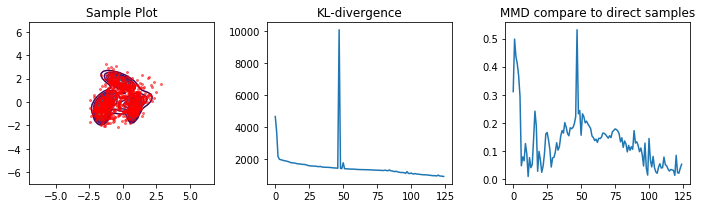

In [83]:
plt.clf()
fig,ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].contour(x1,x2,P,30)
fcn.update(noise)
zs = fcn.sampler(noise)
history = fcn.get_history()
#fcn.clean_history()
ax[0].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
ax[0].set_title('Sample Plot')
ax[1].plot(history['kl'])
ax[1].set_title('KL-divergence')
ax[2].plot(history['mmd'])
ax[2].set_title('MMD compare to direct samples')
#fcn.clean_history()
fig.tight_layout()
plt.show()

In [84]:
model_comparison['DeepVI_FCN'] = [zs, history['kl'], history['mmd']]

### Planar Normalizing Flow

In [34]:
class NormalizingFlowVIN(DeepVariationalInference):
    
    def __init__(self, latent_dim, mus, covs, layer_num=1):
        self.layer_num = layer_num
        super(NormalizingFlowVIN, self).__init__(latent_dim, mus, covs)
    
    def get_name(self):
        return "NF"
    
    def build_graph(self):
        
        with tf.variable_scope('dvi'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self.latent_dim])
            with tf.variable_scope('projector'):
                self.obs, logdet = planar_projector(self.noise, self.layer_num, self.latent_dim)
            with tf.variable_scope('log-det'):
                self.logdet = logdet
            
            trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "dvi/projector")
            
            with tf.variable_scope('log-like'):
                probs = tf.reduce_sum(
                    tf.map_fn(self.distrib.prob, 
                              tf.reshape(tf.tile(self.obs,[1,self.num_cluster]),
                                         [-1,self.num_cluster,self.latent_dim])), 
                    axis=1)
                self.loglike = -tf.log(probs+1e-30)
            with tf.variable_scope('loss'):
                self.loss = tf.reduce_sum(self.logdet + self.loglike)
                
                with tf.variable_scope('optimizer'):
                    #optimizer = self.optimizer(learning_rate=self.learning_rate) 
                    self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=self.loss, 
                                                                            method='L-BFGS-B', 
                                                                            var_list=trainable_variables,
                                                                            options={'maxiter': 100})
                    
#             with tf.variable_scope('training-step'):
#                 self.train = optimizer.minimize(loss=self.loss, var_list=trainable_variables)
      
    def call_back(self, loss, obs):
        self.history['kl'].append(loss)
        self.history['mmd'].append(maximum_mean_discrepancy(obs))
    
    def update(self, noise):
        self.optimizer.minimize(session=self._sesh, 
                                feed_dict={self.noise:noise},
                                loss_callback=self.call_back,
                                fetches=[self.loss, self.obs]
                               )
    
    def sampler(self, noise):
        sample = self._sesh.run(self.obs, feed_dict={self.noise:noise})
        return sample

### 8 layers

In [35]:
tf.reset_default_graph()
nf = NormalizingFlowVIN(2, mus, covs, 8)

In [36]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "dvi/projector")

[<tf.Variable 'dvi/projector/planar_1/w:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_1/u:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_1/b:0' shape=() dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_2/w:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_2/u:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_2/b:0' shape=() dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_3/w:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_3/u:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_3/b:0' shape=() dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_4/w:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_4/u:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_4/b:0' shape=() dtype=float32_ref>,
 <tf.Variable 'dvi/projector/planar_5/w:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'dvi/projector

INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 1270.812012
  Number of iterations: 101
  Number of functions evaluations: 116


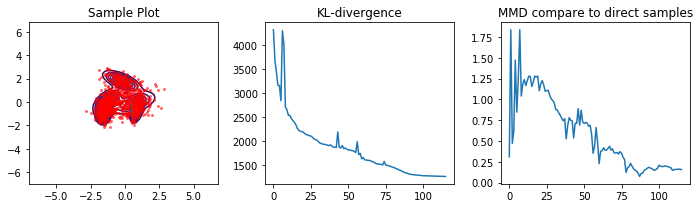

In [37]:
noise = np.random.normal(size=[1000, 2])
plt.clf()
fig,ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].contour(x1,x2,P,30)
nf.update(noise)
zs = nf.sampler(noise)
history = nf.get_history()
#fcn.clean_history()
ax[0].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
ax[0].set_title('Sample Plot')
ax[1].plot(history['kl'])
ax[1].set_title('KL-divergence')
ax[2].plot(history['mmd'])
ax[2].set_title('MMD compare to direct samples')
nf.clean_history()
fig.tight_layout()
plt.show()

In [38]:
model_comparison['DeepVI_NF'] = [zs, history['kl'], history['mmd']]

## Summary

In [46]:
import pickle

In [47]:
with open('model_comparison.pickle', 'wb') as handle:
    pickle.dump(model_comparison, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
with open('model_comparison.pickle', 'rb') as handle:
    model_comparison = pickle.load(handle)

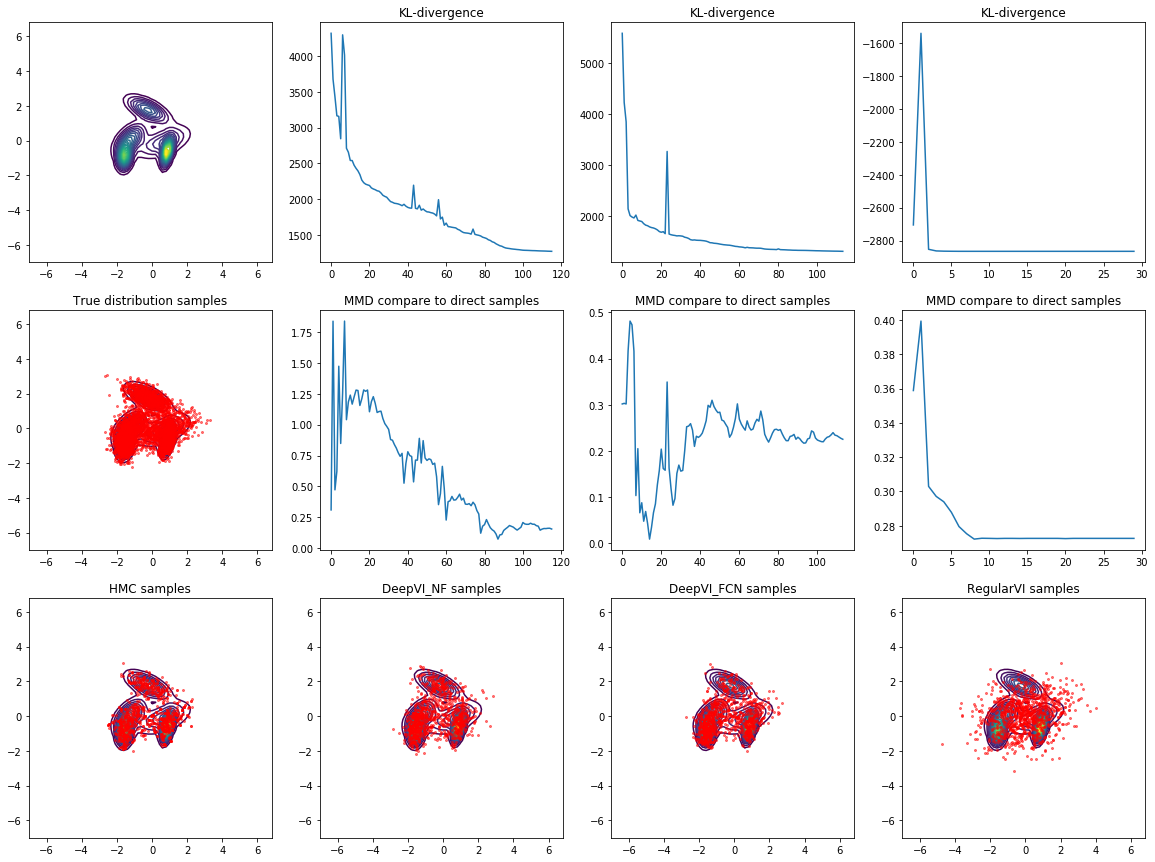

In [49]:
plt.clf()

xs = arange(-7,7,.2)
x1,x2 = meshgrid(xs,xs)

fig,ax = plt.subplots(3, 4, figsize=(20, 15))
keys = model_comparison.keys()
ax[0,0].contour(x1,x2,model_comparison['True'][1],30)
ax[1,0].contour(x1,x2,model_comparison['True'][1],30)
ax[1,0].plot(model_comparison['True'][0][:,0],model_comparison['True'][0][:,1],'ro',markersize=2, alpha=.5)
ax[1,0].set_title('True distribution samples')
ax[2,0].contour(x1,x2,model_comparison['True'][1],30)
ax[2,0].plot(model_comparison['HMC'][0][:,0],model_comparison['HMC'][0][:,1],'ro',markersize=2, alpha=.5)
ax[2,0].set_title('HMC samples')
keys.remove('True')
keys.remove('HMC')

for i, key in enumerate(keys):
    ax[2,i+1].contour(x1,x2,model_comparison['True'][1],30)
    ax[2,i+1].plot(model_comparison[key][0][:,0], 
                 model_comparison[key][0][:,1],
                 'ro',markersize=2, alpha=.5)
    ax[2,i+1].set_title(key+' samples')
    ax[0,i+1].plot(model_comparison[key][1])
    ax[0,i+1].set_title('KL-divergence')
    ax[1,i+1].plot(model_comparison[key][2])
    ax[1,i+1].set_title('MMD compare to direct samples')
    
    
plt.show()

In [85]:
keys

['DeepVI_NF', 'DeepVI_FCN', 'RegularVI']

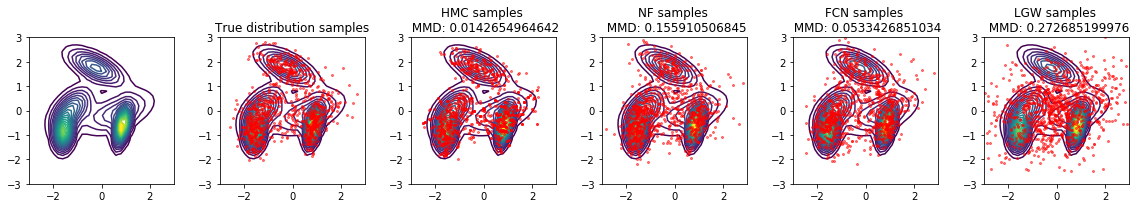

In [91]:
plt.clf()

def set_range(ax):
    l = 3 
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)

xs = arange(-7,7,.2)
x1,x2 = meshgrid(xs,xs)

fig,ax = plt.subplots(1, 6, figsize=(16, 3))
keys = model_comparison.keys()
ax[0].contour(x1,x2,model_comparison['True'][1],30)
set_range(ax[0])
ax[1].contour(x1,x2,model_comparison['True'][1],30)
ax[1].plot(model_comparison['True'][0][:,0],model_comparison['True'][0][:,1],'ro',markersize=2, alpha=.5)
ax[1].set_title('True distribution samples')
set_range(ax[1])
ax[2].contour(x1,x2,model_comparison['True'][1],30)
ax[2].plot(model_comparison['HMC'][0][:,0],model_comparison['HMC'][0][:,1],'ro',markersize=2, alpha=.5)
ax[2].set_title('HMC samples \n MMD: {0}'.format(model_comparison['HMC'][2]))
set_range(ax[2])
keys.remove('True')
keys.remove('HMC')

names = ['NF', 'FCN', 'LGW']

for i, key in enumerate(keys):
    ax[i+3].contour(x1,x2,model_comparison['True'][1],30)
    ax[i+3].plot(model_comparison[key][0][:,0], 
                 model_comparison[key][0][:,1],
                 'ro',markersize=2, alpha=.5)
    ax[i+3].set_title(names[i]+' samples \n MMD: {0}'.format(model_comparison[key][2][-1]))
    set_range(ax[i+3])
#     ax[0,i+1].plot(model_comparison[key][1])
#     ax[0,i+1].set_title('KL-divergence')
#     ax[1,i+1].plot(model_comparison[key][2])
#     ax[1,i+1].set_title('MMD compare to direct samples')
    
plt.tight_layout()    
fig.savefig('gmm.pdf', format='pdf')